## Установка зависимостей

In [ ]:
# Установка необходимых пакетов
!pip install opencv-python-headless
!pip install scikit-learn


In [ ]:
# Подключение модулей
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# Загрузка изображения из файловой системы Colab или загрузка по URL
from google.colab import files
uploaded = files.upload()  # Загрузите файл изображения вручную через эту команду
IMAGE_PATH = next(iter(uploaded))  # В Colab загрузится первый файл

Saving 1695128011374.jpg to 1695128011374.jpg
Saving 1695138157752.jpg to 1695138157752.jpg
Saving 1695138157776.jpg to 1695138157776.jpg
Saving 1695138157794.jpg to 1695138157794.jpg
Saving 1695138157805.jpg to 1695138157805.jpg
Saving 1725544579789.jpg to 1725544579789.jpg


## Выделение + вращение цифр

<ipython-input-10-a4047404ea3f>:58: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-10-a4047404ea3f>:121: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Сохранено изображение: cropped_image_0.png
Сохранено изображение: cropped_image_1.png
Сохранено изображение: cropped_image_2.png
Сохранено изображение: cropped_image_16.png


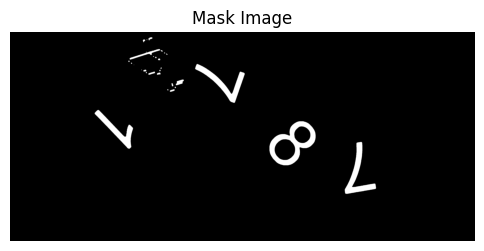

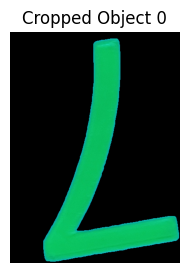

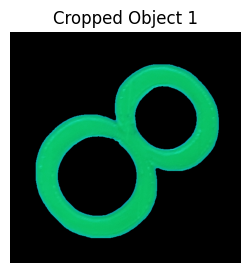

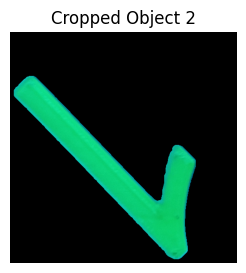

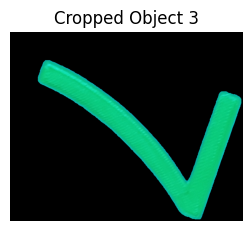

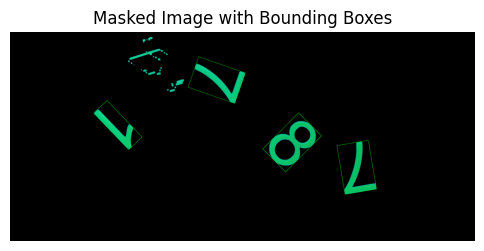

Сохранено повернутое изображение с черным запасом: rotated_image_0.png
Сохранено повернутое изображение с черным запасом: rotated_image_1.png
Сохранено повернутое изображение с черным запасом: rotated_image_2.png
Сохранено повернутое изображение с черным запасом: rotated_image_3.png


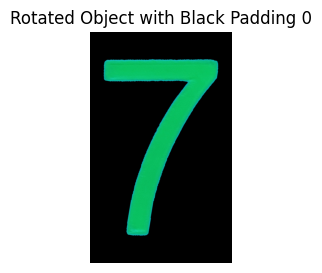

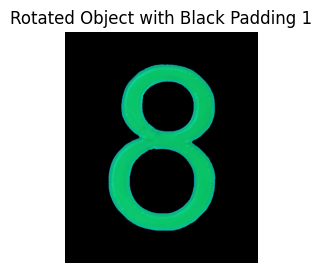

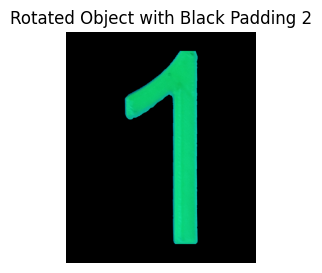

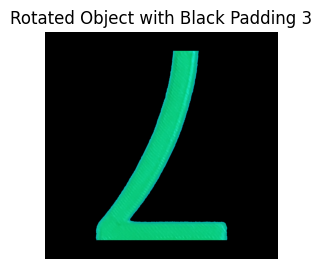

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_center_of_mass(contour):
    moments = cv2.moments(contour)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        return cx, cy
    return None

# Функция для проверки на горизонтальную симметрию
def is_horizontally_symmetric(contour):
    x, y, w, h = cv2.boundingRect(contour)
    center_x = x + w // 2

    left_side = contour[contour[:, :, 0] < center_x]
    right_side = contour[contour[:, :, 0] > center_x]

    if len(left_side) > 0 and len(right_side) > 0:
        left_area = cv2.contourArea(left_side) if len(left_side) > 0 else 0
        right_area = cv2.contourArea(right_side) if len(right_side) > 0 else 0
        return abs(left_area - right_area) < 0.1 * max(left_area, right_area)

    return False

# Функция для проверки на перевернутость
def is_inverted_v2(contour):
    if is_horizontally_symmetric(contour):
        return False

    x, y, w, h = cv2.boundingRect(contour)
    center_of_mass = calculate_center_of_mass(contour)
    if center_of_mass:
        _, center_y = center_of_mass
        if center_y > (y + h // 2):
            return False
        else:
            return True

    return False

# Функция для поворота изображения
def rotate_image(image, angle, center):
    if image.shape[0] > 0 and image.shape[1] > 0:  # Проверяем, что размеры изображения больше 0
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)
        return rotated_image
    else:
        print("Предупреждение: Попытка повернуть пустое изображение")
        return image  # Возвращаем исходное изображение без изменений

# Функция для вырезания области по минимальному прямоугольнику
def crop_min_area_rect(image, rect):
    # Получаем координаты точек прямоугольника
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Получаем координаты для вырезания области
    min_x = int(min(box[:, 0]))
    max_x = int(max(box[:, 0]))
    min_y = int(min(box[:, 1]))
    max_y = int(max(box[:, 1]))

    # Вырезаем область из изображения
    cropped_img_area = image[min_y:max_y, min_x:max_x]
    return cropped_img_area

# Основная функция обработки изображения
def process_img(img, color):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Применяем маску HSV
    img_mask = cv2.inRange(img_hsv, color[0], color[1])

    # Применяем морфологические операции для улучшения маски
    kernel = np.ones((5, 5), np.uint8)  # Определяем ядро для морфологических операций

    # Открытие: удаляет мелкие объекты (первоначальная эрозия + дилатация)
    img_mask = cv2.morphologyEx(img_mask, cv2.MORPH_OPEN, kernel)

    # Закрытие: заполняет небольшие дырки внутри объектов (дилатация + эрозия)
    img_mask = cv2.morphologyEx(img_mask, cv2.MORPH_CLOSE, kernel)

    # Применяем медианный фильтр для сглаживания маски
    img_mask = cv2.medianBlur(img_mask, 5)

    # Применяем гауссовое размытие для улучшения качества маски
    img_mask = cv2.GaussianBlur(img_mask, (5, 5), 0)

    # Применяем битовую операцию AND для маски и исходного изображения
    masked_img = cv2.bitwise_and(img, img, mask=img_mask)

    # Поиск контуров
    contours, _ = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cropped_images = []
    img_with_boxes = masked_img.copy()  # Копия маскированного изображения для отображения рамок

    if contours:
        for idx, cnt in enumerate(contours):
            if cv2.contourArea(cnt) < 15000:  # Пропускаем слишком маленькие объекты
                continue

            # Получаем минимальный повёрнутый прямоугольник
            rect = cv2.minAreaRect(cnt)

            # Вырезаем область из изображения по минимальному прямоугольнику
            cropped_img_area = crop_min_area_rect(masked_img, rect)

            # Проверка на пустую область
            if cropped_img_area.size == 0:
                print(f"Ошибка: вырезанная область для контура {idx} пуста.")
                continue

            cropped_images.append(cropped_img_area)

            # Получаем координаты точек прямоугольника
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            # Рисуем рамку вокруг объекта на копии маскированного изображения
            cv2.polylines(img_with_boxes, [box], isClosed=True, color=(0, 255, 0), thickness=2)

            # Сохраняем вырезанное изображение
            cropped_filename = f"cropped_image_{idx}.png"
            cv2.imwrite(cropped_filename, cropped_img_area)  # Сохраняем объект по рамке
            print(f"Сохранено изображение: {cropped_filename}")

    return img_mask, cropped_images, img_with_boxes

# Функция для поворота объектов на меньшую сторону минимальной рамки с запасом по высоте
def rotate_to_smaller_side(cropped_images):
    rotated_images = []
    for idx, cropped_img in enumerate(cropped_images):
        # Преобразуем изображение в серый цвет для нахождения контуров
        gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        # Находим контуры на изображении
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            if cv2.contourArea(cnt) < 15000:  # Пропускаем слишком маленькие объекты
                continue

            # Получаем минимальный прямоугольник для текущего объекта
            rect = cv2.minAreaRect(cnt)
            center = tuple(map(int, rect[0]))
            size = rect[1]
            angle = rect[2]

            # Определяем, какая сторона меньше, и поворачиваем изображение
            if size[0] > size[1]:
                angle = angle + 90  # Меняем угол, чтобы меньшая сторона стала горизонтальной

            if is_inverted_v2(cnt):
                angle += 180

            # Поворачиваем изображение, чтобы меньшая сторона прямоугольника стала горизонтальной
            rotated_img = rotate_image(cropped_img, angle, center)

            # Проверяем, нужно ли дополнительно повернуть на 180 градусов
            # if check_digit_orientation(rotated_img, cnt):  # Если объект перевернут, поворачиваем его на 180°
                # rotated_img = cv2.rotate(rotated_img, cv2.ROTATE_180)

            # Добавляем черный запас по высоте
            rotated_h, rotated_w = rotated_img.shape[:2]
            padding_height = int(rotated_h * 0.1)  # 10% запас по высоте

            # Добавляем черный запас
            padded_image = cv2.copyMakeBorder(rotated_img, padding_height, padding_height, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))

            # Сохраняем повернутое изображение с черным запасом
            rotated_filename = f"rotated_image_{idx}.png"
            cv2.imwrite(rotated_filename, padded_image)
            print(f"Сохранено повернутое изображение с черным запасом: {rotated_filename}")

            rotated_images.append(padded_image)

    return rotated_images

# Задаем диапазоны HSV для маски
color_low = (58, 100, 100)
color_high = (85, 255, 255)

# Загрузка изображения
img_path = '1.jpg'
# img_path = '1695128011374.jpg'  # Укажите путь к изображению
# img_path = '1695138157785.jpg'  # Укажите путь к изображению
# img_path = '1695138157752.jpg'  # Укажите путь к изображению
img = cv2.imread(img_path)

# Проверяем, удалось ли загрузить изображение
if img is None:
    print(f"Ошибка: не удалось загрузить изображение по пути {img_path}")
else:
    # Обработка изображения
    img_mask, cropped_images, img_with_boxes = process_img(img, (color_low, color_high))

    # Отображение маски
    plt.figure(figsize=(6, 6))
    plt.imshow(img_mask, cmap='gray')
    plt.title('Mask Image')
    plt.axis('off')
    plt.show()

    # Отображение вырезанных объектов
    for idx, cropped_img in enumerate(cropped_images):
        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Cropped Object {idx}')
        plt.axis('off')
        plt.show()

    # Отображение изображения с рамками (на маскированном изображении)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title('Masked Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

    # Обработка и поворот вырезанных объектов с черным запасом
    rotated_images = rotate_to_smaller_side(cropped_images)

    # Отображение повернутых объектов с запасом
    for idx, rotated_img in enumerate(rotated_images):
        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Rotated Object with Black Padding {idx}')
        plt.axis('off')
        plt.show()


## Обучение модели

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator


(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Изменяем размер данных
x_train = np.array([cv2.resize(img, (56, 56)) for img in x_train])
x_test = np.array([cv2.resize(img, (56, 56)) for img in x_test])

x_train = x_train.reshape(-1, 56, 56, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 56, 56, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Сама модель
model = Sequential()

# Первые сверточные слои
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(56, 56, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # для предотвращения переобучения

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # снижение размерности
model.add(Dropout(0.25))

model.add(Flatten())  # многомерный в одномерный

# Полносвязные слои
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Регуляризация
model.add(Dense(10, activation='softmax'))  # 10 классов для классификации цифр

# Компилирование модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Создание генератора аугментации данных
datagen = ImageDataGenerator(
    rotation_range=5,  # поворот на 5 градусов
    width_shift_range=0.1,  # сдвиг по ширине
    height_shift_range=0.1,  # сдвиг по высоте
    zoom_range=0.2,  # увеличение
    shear_range=0.25,  # сдвиг
    fill_mode='nearest'  # заполнение пустых пикселей
)

# Обучаем модель с аугментацией данных
model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=15, validation_data=(x_test, y_test))

# Сохраняем модель для дальнейшего использования
model.save('mnist_digit_classifier.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.6810 - loss: 0.9579 - val_accuracy: 0.9758 - val_loss: 0.0763
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.9127 - loss: 0.2838 - val_accuracy: 0.9845 - val_loss: 0.0475
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.9320 - loss: 0.2221 - val_accuracy: 0.9877 - val_loss: 0.0354
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.9464 - loss: 0.1839 - val_accuracy: 0.9899 - val_loss: 0.0313
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.9523 - loss: 0.1579 - val_accuracy: 0.9905 - val_loss: 0.0299
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.9559 - loss: 0.1502 - val_accuracy: 0.9914 - val_loss: 0.0298
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.9587 - loss: 0.1367 - val_accuracy: 0.9912 - val_loss: 0.0270
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.9632 - loss: 0.1244 - val_accurac

## Распозначание цифр в одном экземпляре

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


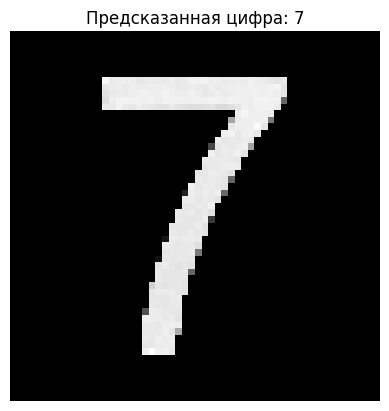

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


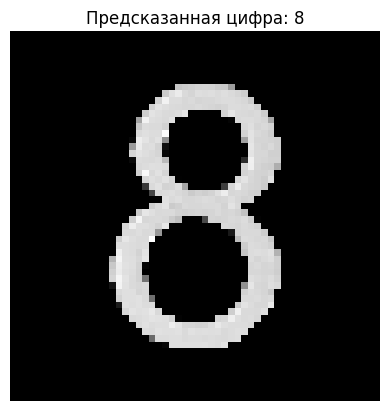

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


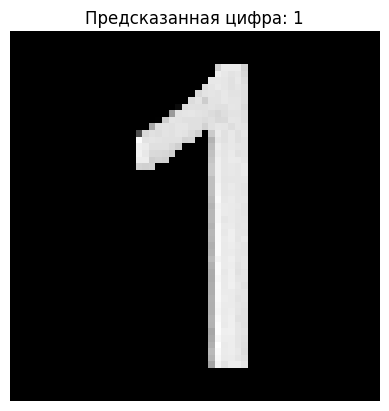

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


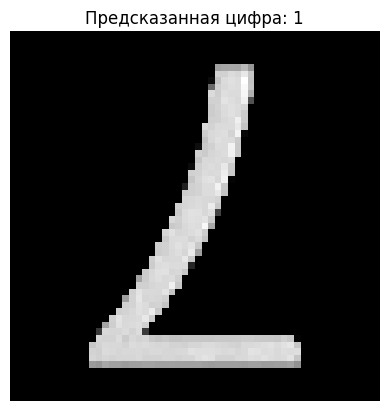

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files


# Функция для предобработки изображения
def preprocess_image(image_path, target_size=(56, 56)):
    # Загружаем изображение в оттенках серого
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Проверяем, загрузилось ли изображение
    if img is None:
        print(f"Ошибка: изображение {image_path} не было загружено.")
        return None

    # Изменяем размер изображения с сохранением соотношения сторон
    h, w = img.shape
    if h > w:
        ratio = target_size[0] / float(h)
        new_width = int(w * ratio)
        new_height = target_size[0]
    else:
        ratio = target_size[1] / float(w)
        new_width = target_size[1]
        new_height = int(h * ratio)

    img_resized = cv2.resize(img, (new_width, new_height))

    # Дополняем изображение до квадрата
    delta_w = target_size[1] - new_width
    delta_h = target_size[0] - new_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    img_square = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    # Нормализуем пиксели (преобразуем значения в диапазон от 0 до 1)
    img_square = img_square.astype('float32') / 255.0

    # Изменяем размер массива для модели (добавляем ось для пакетов и каналов)
    img_square = np.expand_dims(img_square, axis=-1)  # (56, 56, 1)
    img_square = np.expand_dims(img_square, axis=0)   # (1, 56, 56, 1)

    return img_square

# Загрузка предобученной модели
model = load_model('mnist_digit_classifier.h5')

images_path = [
    'rotated_image_0.png',
    'rotated_image_1.png',
    'rotated_image_2.png',
    'rotated_image_3.png',
]

# Применим распознавание ко всем загруженным изображениям
for image_name in images_path:
    # Предобработка изображения
    processed_image = preprocess_image(image_name, target_size=(56, 56))

    if processed_image is not None:  # Проверка, успешно ли обработано изображение
        # Предсказание
        prediction = model.predict(processed_image)
        predicted_digit = np.argmax(prediction, axis=1)[0]

        # Отображаем изображение и его предсказание
        plt.imshow(processed_image[0, :, :, 0], cmap='gray')
        plt.title(f'Предсказанная цифра: {predicted_digit}')
        plt.axis('off')  # Убираем оси
        plt.show()



## Распознавание цифр в двух экземплярах (оригинал и перевернутое)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


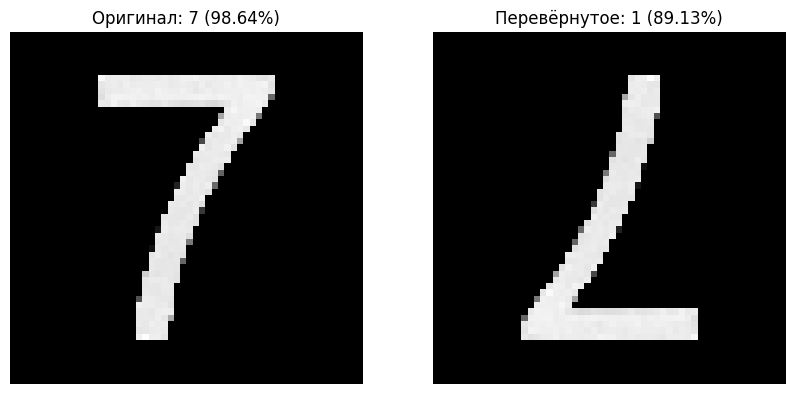

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


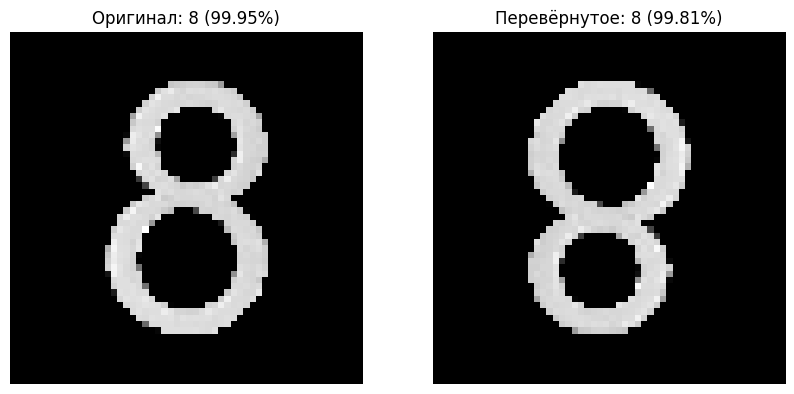

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


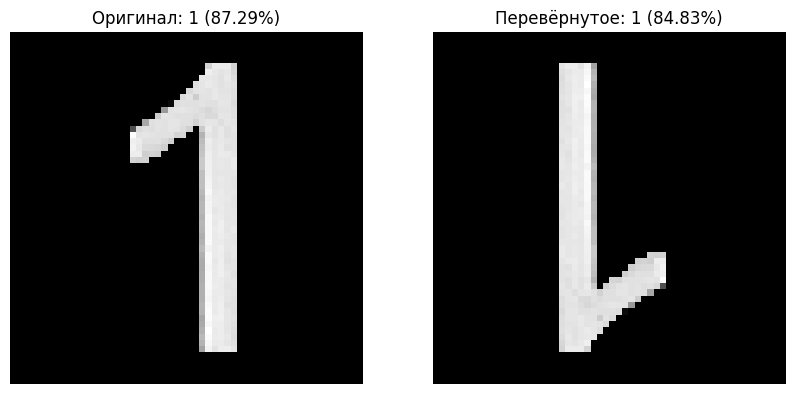

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


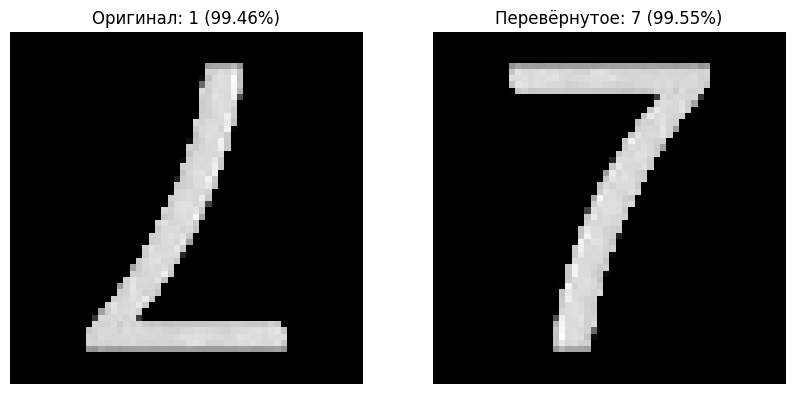

Ошибка: изображение rotated_image_4.png не было загружено.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Функция для предобработки изображения
def preprocess_image(image_path, target_size=(56, 56)):
    # Загружаем изображение в оттенках серого
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Проверяем, загрузилось ли изображение
    if img is None:
        print(f"Ошибка: изображение {image_path} не было загружено.")
        return None

    # Изменяем размер изображения с сохранением соотношения сторон
    h, w = img.shape
    if h > w:
        ratio = target_size[0] / float(h)
        new_width = int(w * ratio)
        new_height = target_size[0]
    else:
        ratio = target_size[1] / float(w)
        new_width = target_size[1]
        new_height = int(h * ratio)

    img_resized = cv2.resize(img, (new_width, new_height))

    # Дополняем изображение до квадрата
    delta_w = target_size[1] - new_width
    delta_h = target_size[0] - new_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    img_square = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    # Нормализуем пиксели (преобразуем значения в диапазон от 0 до 1)
    img_square = img_square.astype('float32') / 255.0

    # Изменяем размер массива для модели (добавляем ось для пакетов и каналов)
    img_square = np.expand_dims(img_square, axis=-1)  # (56, 56, 1)
    img_square = np.expand_dims(img_square, axis=0)   # (1, 56, 56, 1)

    return img_square


# Функция для поворота изображения на 180 градусов
def rotate_image(image):
    # Убираем лишние оси, чтобы остался 2D массив
    image_2d = image[0, :, :, 0]  # (56, 56)

    # Поворачиваем изображение на 180 градусов
    rotated_image_2d = cv2.rotate(image_2d, cv2.ROTATE_180)

    # Возвращаем изображение в нужную форму (1, 56, 56, 1)
    rotated_image = np.expand_dims(rotated_image_2d, axis=-1)  # (56, 56, 1)
    rotated_image = np.expand_dims(rotated_image, axis=0)  # (1, 56, 56, 1)

    return rotated_image


# Загрузка предобученной модели
model = load_model('mnist_digit_classifier.h5')

images_path = [
    'rotated_image_0.png',
    'rotated_image_1.png',
    'rotated_image_2.png',
    'rotated_image_3.png',
    'rotated_image_4.png'
]

# Применим распознавание ко всем загруженным изображениям
for image_name in images_path:
    # Предобработка изображения (оригинала)
    processed_image = preprocess_image(image_name, target_size=(56, 56))

    if processed_image is not None:  # Проверка, успешно ли обработано изображение
        # Распознавание оригинала
        prediction_original = model.predict(processed_image)
        predicted_digit_original = np.argmax(prediction_original, axis=1)[0]
        confidence_original = np.max(prediction_original) * 100  # Уверенность в %

        # Создаём копию обработанного изображения, чтобы повернуть её
        rotated_processed_image = np.copy(processed_image)

        # Переворачиваем обработанное изображение
        rotated_processed_image = rotate_image(rotated_processed_image)

        # Распознавание перевёрнутого изображения
        prediction_rotated = model.predict(rotated_processed_image)
        predicted_digit_rotated = np.argmax(prediction_rotated, axis=1)[0]
        confidence_rotated = np.max(prediction_rotated) * 100  # Уверенность в %

        # Отображение оригинала и перевёрнутого изображения с результатами
        plt.figure(figsize=(10, 5))

        # Оригинальное изображение
        plt.subplot(1, 2, 1)
        plt.imshow(processed_image[0, :, :, 0], cmap='gray')
        plt.title(f'Оригинал: {predicted_digit_original} ({confidence_original:.2f}%)')
        plt.axis('off')

        # Перевёрнутое изображение
        plt.subplot(1, 2, 2)
        plt.imshow(rotated_processed_image[0, :, :, 0], cmap='gray')
        plt.title(f'Перевёрнутое: {predicted_digit_rotated} ({confidence_rotated:.2f}%)')
        plt.axis('off')

        # Показать результаты
        plt.show()
